In [1]:
from tqdm.auto import tqdm
import torch 
from transformers import DistilBertModel
from transformers import DistilBertTokenizer
from transformers import PreTrainedTokenizer
from sentence_transformers import SentenceTransformer, SentencesDataset, InputExample, losses
from datasets import Dataset
import pandas as pd
from transformers.optimization import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt 
import numpy as np
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
from torch.nn import CosineEmbeddingLoss
import sklearn
import spacy
from torch import nn
#Build up to SBERT model 

In [2]:
deviceNum = 1

device = torch.device("cuda:" + str(deviceNum) if torch.cuda.is_available() else "cpu")

def check_mem():
    torch.cuda.empty_cache()
    a = torch.cuda.memory_allocated(deviceNum)/1024/1024/1024
    r = torch.cuda.memory_reserved(deviceNum)/1024/1024/1024
    print("torch.cuda.memory_allocated: %fGB"%a)
    print("torch.cuda.memory_reserved: %fGB"%r)
    print("torch.cuda.memory_free: %fGB"%(r-a))
    print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(deviceNum)/1024/1024/1024))
check_mem()


torch.manual_seed(0)

df = pd.read_csv("/shared/3/projects/benlitterer/localNews/NetworkMVP/enTrainData.csv", sep="\t")
df = df.loc[(df["url1_lang"] == "en") & (df["url2_lang"] == "en")]

#put ground truth values into a list 
df["ground_truth"] = df['Overall']

#get only the columns we need 
#TODO: do we need "pair_id"? 
leanDf = df[["ground_truth",  'text1', 'text2']].dropna()

#rescale data from (0, 4): (0, 1)
leanDf["ground_truth"] = 1 - ((leanDf["ground_truth"] - 1) / 3)

torch.cuda.memory_allocated: 0.000000GB
torch.cuda.memory_reserved: 0.000000GB
torch.cuda.memory_free: 0.000000GB
torch.cuda.max_memory_reserved: 0.000000GB


In [3]:
class CustomSentListDataset(Dataset): 
    def __init__(self, inDf): 
        self.inDf = inDf 
        
    def __len__(self): 
        return len(self.inDf)
    
    def __getitem__(self, idx):
        return list(self.inDf.iloc[idx])

In [4]:
#nlp = spacy.load("en_core_web_sm", disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer", "ner"])
#nlp.enable_pipe("senter")
nlp = spacy.blank("en")
nlp.add_pipe("sentencizer")

def extractSents(inList): 
    separator = nlp.pipe(inList, n_process=8)
    textList = []
    for text in tqdm(separator): 
        sentList = [str(sent) for sent in text.sents if len(sent) > 3]
        textList.append(sentList)
    return textList

#split data 
trainDf, validDf = sklearn.model_selection.train_test_split(leanDf, train_size=.9, test_size=.1)
trainDf = trainDf.reset_index(drop=True)
validDf = validDf.reset_index(drop=True)

trainDf["text1"] = extractSents(trainDf["text1"])
trainDf["text2"] = extractSents(trainDf["text2"])
validDf["text1"] = extractSents(validDf["text1"])
validDf["text2"] = extractSents(validDf["text2"])



0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [5]:
sentCutoff = 60
 
trainDf["text1"] = trainDf["text1"].apply(lambda x: x[:sentCutoff])
trainDf["text2"] = trainDf["text2"].apply(lambda x: x[:sentCutoff])

validDf["text1"] = validDf["text1"].apply(lambda x: x[:sentCutoff])
validDf["text2"] = validDf["text2"].apply(lambda x: x[:sentCutoff])


In [6]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')

def getLoader(inDf, batchSize): 
    inDf["text1"] = inDf["text1"].apply(lambda x: tokenizer.batch_encode_plus(x, max_length=60, padding="max_length", truncation=True, return_tensors="pt"))
    inDf["text2"] = inDf["text2"].apply(lambda x: tokenizer.batch_encode_plus(x, max_length=60, padding="max_length", truncation=True, return_tensors="pt"))
    
    inDf["text1_input_ids"] = inDf["text1"].apply(lambda x: x["input_ids"])
    inDf["text2_input_ids"] = inDf["text2"].apply(lambda x: x["input_ids"])
    
    inDf["text1_attention_mask"] = inDf["text1"].apply(lambda x: x["attention_mask"])
    inDf["text2_attention_mask"] = inDf["text2"].apply(lambda x: x["attention_mask"])
    
    #inDf["ground_truth"] = inDf["ground_truth"].apply(lambda x: x))
    
    dataset = CustomSentListDataset(inDf[["ground_truth", "text1_input_ids", "text1_attention_mask","text2_input_ids", "text2_attention_mask"]])
    
    # convert dataset features to PyTorch tensors
    #dataset.set_format(type='torch', columns=inDf.columns())
    loader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=True)
    return [dataset, loader]

trainData, trainLoader = getLoader(trainDf, 1)
validData, validLoader = getLoader(validDf, 1)


In [7]:
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
cos(torch.Tensor([0]), torch.Tensor([0]))

tensor(0.)

In [8]:
#NOTE: originally universal sentence encoder was fed in as well as mp-net encoding. That's why 
#they have dimension of two going into the network 
class BigModel(nn.Module): 
    def __init__(self, sentCutoff, dropout): 
        super(BigModel, self).__init__()
        
        #need encoder first 
        self.model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2')
        self.cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
        self.sentCutoff = sentCutoff
        self.loss_func = torch.nn.MSELoss(reduction="mean")
        
        N_UNITS = 5
        self.in_1 = SimCnnSubPart(kernel_size=5, dropout=dropout)
        self.in_2 = SimCnnSubPart(kernel_size=7, dropout=dropout)
        self.in_3 = SimCnnSubPart(kernel_size=10, dropout=dropout)
        self.in_4 = SimCnnSubPart(kernel_size=12, dropout=dropout)
        self.in_5 = SimCnnSubPart(kernel_size=15, dropout=dropout)
        
        self.out = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=128*N_UNITS, out_features=128*(N_UNITS-2)),
            nn.ReLU6(),
            nn.Linear(in_features=128*(N_UNITS-2), out_features=128*(N_UNITS-3)),
            nn.Dropout(dropout),
            nn.ReLU6(),
            nn.Linear(in_features=128*(N_UNITS-3), out_features=128*(N_UNITS-4)),
            nn.ReLU6(),
            nn.Linear(in_features=128*(N_UNITS-4), out_features=64),
            nn.Dropout(dropout),
            nn.ReLU6(),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU6(),
            nn.Linear(in_features=32, out_features=1),
        )
        
        """
        self.out = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=128, out_features=int(128/3)),
            nn.ReLU6(),
            nn.Linear(in_features=int(128/3), out_features=int(128/6)),
            nn.Dropout(dropout),
            nn.ReLU6(),
            nn.Linear(in_features=int(128/6), out_features=int(128/8)),
            nn.ReLU6(),
            nn.Linear(in_features=int(128/8), out_features=1)
        )
        """
    def forward(self, inputs_ids_a, attention_a, inputs_ids_b, attention_b, gt):
        u = self.model(inputs_ids_a, attention_mask=attention_a)[0]  # all token embeddings B

        #try to clear up memory and keep only the sentence embeddings 
        del inputs_ids_a

        sents_u = self.mean_pooling(u, attention_a)
        del attention_a
        del u 

        v = self.model(inputs_ids_b, attention_mask=attention_b)[0]  # all token embeddings B
        del inputs_ids_b

        sents_v = self.mean_pooling(v, attention_b)
        del attention_b
        del v

        #print("creating matrix")
        #get similarity matrix for sentences between the documents 
        sims = np.empty([self.sentCutoff, self.sentCutoff])
        for i in range(self.sentCutoff):
            uSent = torch.Tensor([0]).to(device)
            if i < len(sents_u): 
                uSent = sents_u[i]
            for j in range(self.sentCutoff):
                vSent = torch.Tensor([0]).to(device)
                if j < len(sents_v):
                    vSent = sents_v[j]
                sims[i, j] = self.cos(uSent, vSent)

        sims = torch.Tensor(np.array([sims])).to(device).unsqueeze(1)
        del sents_u
        del sents_v 

        #print(sims.shape)
        x_1 = self.in_1(sims)
        #print(x_1.shape)
        x_2 = self.in_2(sims)
        x_3 = self.in_3(sims)
        x_4 = self.in_4(sims)
        x_5 = self.in_5(sims)
        x_cat = torch.cat([x_1, x_2, x_3, x_4, x_5], dim=1)
        #x_cat = x_3 
        #print(x_cat.shape)
        
        pred = self.out(x_cat)
        
        gt = gt.unsqueeze(1)
            
        loss = self.loss_func(pred, gt)
        
        return [loss, pred, gt] 

    
    def mean_pooling(self, token_embeddings, attention_mask): 
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

class MaxOverTimePooling(nn.Module):

    def __init__(self):
        super(MaxOverTimePooling, self).__init__()

    def forward(self, x):
        pool = nn.MaxPool2d(kernel_size=(x.size()[2], x.size()[3]))
        return pool(x)
    
#perform convolutions with a given kernel_size and flatten down to 128 features 
#note we do feature extraction, dropout, and pooling here  
class SimCnnSubPart(nn.Module):
    def __init__(self, kernel_size: int, dropout: float):
        super(SimCnnSubPart, self).__init__()
        
        
        self.network_1 = nn.Sequential(
            #NOTE: chaning this to 1 but maybe should be 2? 
            CnnBlock(in_channels=1, out_channels=32, kernel_size=kernel_size, dropout=(dropout / 2.0)),
            nn.Dropout(dropout / 2),
            CnnBlock(in_channels=32, out_channels=64, kernel_size=kernel_size, dropout=(dropout / 2.0)),
            #used to be 60 
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=kernel_size),
            nn.BatchNorm2d(128),
            nn.ReLU6(),
            MaxOverTimePooling(),
            nn.Flatten(),
            nn.Linear(in_features=128, out_features=128),
            nn.Dropout(dropout),
            nn.ReLU6(),
        )

    def forward(self, x):
        return self.network_1(x)
        # x = self.n_2(x)
        # return x

#create a block of convolutions in a row. Doesn't pool though so just feature extraction basically 
class CnnBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size, dropout: int):
        super(CnnBlock, self).__init__()

        self.c1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding='same'),
            nn.ReLU6(),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding='same'),
            nn.ReLU6(),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(dropout),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding='same'),
            nn.ReLU6(),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding='same'),
            nn.ReLU6(),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(dropout),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding='same'),
            nn.ReLU6(),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        return self.c1(x)

In [9]:

class MyModel(nn.Module):
    def __init__(self, sentCutoff):
        #do all the stuff from the inhereted method 
        super(MyModel,self).__init__()
        
        #need encoder first 
        self.model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2')
        self.cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
        self.sentCutoff = sentCutoff
        
        #Now start CNN
        #layer1 
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=100, kernel_size=11, stride = 1, padding=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.ReLU1 = nn.ReLU()
        
        #layer2
        self.conv2 = nn.Conv2d(in_channels=100, out_channels=50, kernel_size=5, stride = 1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.ReLU2 = nn.ReLU()
        
        #layer 3 
        self.conv3 = nn.Conv2d(in_channels=50, out_channels=10, kernel_size=5, stride = 1, padding=0)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.ReLU3 = nn.ReLU()
        
        #layer 4
        self.l1 = nn.Linear(250, 50)
        self.ReLU4 = nn.ReLU()
        
        #layer 5 
        self.l2 = nn.Linear(50, 1)
        
        self.loss_func = torch.nn.MSELoss(reduction="mean")
        
    def mean_pooling(self, token_embeddings, attention_mask): 
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def forward(self, inputs_ids_a, attention_a, inputs_ids_b, attention_b, gt): 
        
        #out = out.view(out.size(0), -1)
        
        u = self.model(inputs_ids_a, attention_mask=attention_a)[0]  # all token embeddings B
        #try to clear up memory and keep only the sentence embeddings 
        del inputs_ids_a

        sents_u = self.mean_pooling(u, attention_a)
        del attention_a
        del u 
        
        v = self.model(inputs_ids_b, attention_mask=attention_b)[0]  # all token embeddings B
        del inputs_ids_b

        sents_v = self.mean_pooling(v, attention_b)
        del attention_b
        del v
     
        #print("creating matrix")
        #get similarity matrix for sentences between the documents 
        sims = np.empty([self.sentCutoff, self.sentCutoff])
        for i in range(self.sentCutoff):
            uSent = torch.Tensor([0]).to(device)
            if i < len(sents_u): 
                uSent = sents_u[i]
            for j in range(self.sentCutoff):
                vSent = torch.Tensor([0]).to(device)
                if j < len(sents_v):
                    vSent = sents_v[j]
                sims[i, j] = self.cos(uSent, vSent)

        sims = torch.Tensor(np.array([sims])).to(device)
        del sents_u
        del sents_v 

        #print(sims.shape)
        #print("created matrix")
        #first attempt is a single linear layer
        #maybe linear combination of output is sufficient? 
        #go from 4000 > 500 > 1
        out = self.conv1(sims)
        out = self.pool1(out)
        out = self.ReLU1(out)
        
        #print(out.shape)
        #print("l1 finished")
        out = self.conv2(out)
        out = self.pool2(out)
        out = self.ReLU2(out)
        
        #print(out.shape)
        #print("l2 finished")
        out = self.conv3(out)
        out = self.pool3(out)
        out = self.ReLU3(out)
        #print(out.shape)
        #print(out)
        out = out.view(1, out.shape[0]*out.shape[1]*out.shape[2])
        
        #print(out.shape)
        #print("l3 finished")
        out = self.l1(out)
        out = self.ReLU4(out)
        
        #print("l4 finished")
        pred = self.l2(out)
        
        #since the first dimension is supposed to represent number of batches, we add 
        # a dimension to the prediction to indicate batch size of 1
        gt = gt.unsqueeze(1)
       
        #print(pred.shape)
        #print(gt.shape)
        
        loss = self.loss_func(pred, gt)
        
        return [loss, pred, gt] 


In [10]:
x = torch.Tensor(np.empty([10, 5, 5]))
x = x.view(1, x.shape[0]*x.shape[1]*x.shape[2])


In [11]:
model = BigModel(50, .5).to(device)

trainBatch = 1

# we would initialize everything first
optim = torch.optim.Adam(model.parameters(), lr=2e-5)

# and setup a warmup for the first ~10% steps
total_steps = int(len(trainData) / trainBatch)
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps=warmup_steps, num_training_steps=total_steps - warmup_steps)

In [12]:
def validation(): 
    model.eval()
    lossList = []
    preds = []
    gts = []

    vLoop = tqdm(validLoader, leave=True)
    for j, vBatch in enumerate(vLoop): 
        # prepare batches and more all to the active device
        inputs_ids_a = vBatch[1][0].to(device)
        attention_a = vBatch[2][0].to(device)
        inputs_ids_b = vBatch[3][0].to(device)
        attention_b = vBatch[4][0].to(device)
        gt = vBatch[0].float().to(device)
        
        #get outputs from model 
        loss, pred, gt = model(inputs_ids_a, attention_a, inputs_ids_b, attention_b, gt)
        
        #get predictions and ground truth to compute training metrics with 
        lossList.append(float(loss))
        preds.append(float(pred))
        gts.append(float(gt))
        
    #print(vGT)
    return [lossList, preds, gts]
        

In [13]:
lossSmoothing = 20
validationFreq = 500

#TODO: implement a cutoff on how many sentences of the article we can consider 
#TODO: put model in seperate class? How to make sure the params are updating 
trainDict = {}
lossList = []
subLossList = []
validMetrics = []
# increase from 1 epoch if need be 
for epoch in range(1):
    
    model.train()  # make sure model is in training mode
    
    # initialize the dataloader loop with tqdm (tqdm == progress bar)
    loop = tqdm(trainLoader, leave=True)
    
    for i, batch in enumerate(loop): 
        # zero all gradients on each new step
        optim.zero_grad()
        
        #in practice this doesn't seem to usually actually help but worth adding? 
        #torch.cuda.empty_cache()

        #get model inputs from batch 
        inputs_ids_a = batch[1][0].to(device)
        attention_a = batch[2][0].to(device)
        inputs_ids_b = batch[3][0].to(device)
        attention_b = batch[4][0].to(device)
        gt = batch[0].float().to(device)

        #get outputs from model 
        loss, pred, gt = model(inputs_ids_a, attention_a, inputs_ids_b, attention_b, gt)
        
        subLossList.append(loss.item())
        if i % lossSmoothing == 0: 
            lossList.append(np.median(subLossList))
            subLossList = []
            
        #update weights 
        loss.backward()
        
        #validation if at correct step 
        if i % validationFreq == 0: 
            validMetrics.append(validation())
            model.train()
            print("validated")
            
        optim.step()
        scheduler.step()

  0%|          | 0/1508 [00:00<?, ?it/s]

/opt/anaconda/lib/python3.8/site-packages/torch/nn/modules/conv.py:443: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:744.)
  return F.conv2d(input, weight, bias, self.stride,


  0%|          | 0/168 [00:00<?, ?it/s]

validated


  0%|          | 0/168 [00:00<?, ?it/s]

validated


  0%|          | 0/168 [00:00<?, ?it/s]

validated


  0%|          | 0/168 [00:00<?, ?it/s]

validated


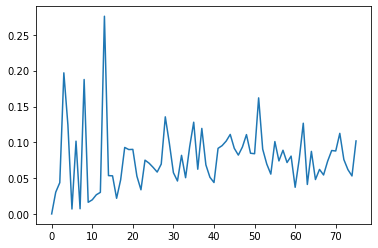

In [14]:
plt.plot(lossList)


Text(0.5, 1.0, 'Loss')

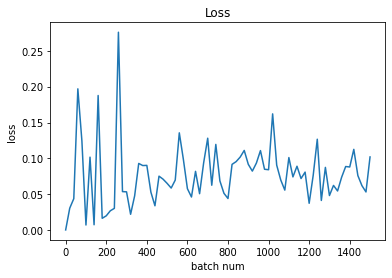

In [15]:
lossIndex = [i * lossSmoothing for i in range(len(lossList))]
plt.plot(lossIndex, lossList)
plt.xlabel("batch num")
plt.ylabel("loss")
plt.title("Loss")

In [16]:
np.array(validMetrics).shape

(4, 3, 168)

In [17]:
validDf = pd.DataFrame({"loss":[], "pred":[], "true":[], "iter":[]})
validArr = np.array(validMetrics)

iterNum = 0
corrList = []
iterList = []
for i in range(validArr.shape[0]): 
    subDf = pd.DataFrame(validArr[i].T)
    subDf.columns = ["loss", "pred", "true"]
    subDf["iter"] = [iterNum for i in range(len(subDf))]
    iterList.append(iterNum)
    iterNum += validationFreq
    validDf = pd.concat([validDf, subDf])
    corr = np.corrcoef(subDf["pred"], subDf["true"])
    corrList.append(corr[0, 1])

Text(0.5, 1.0, 'validation correlation')

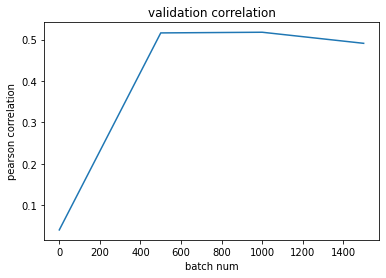

In [18]:
plt.plot(iterList, corrList)
plt.xlabel("batch num")
plt.ylabel("pearson correlation")
plt.title("validation correlation")

[[1.         0.04018502]
 [0.04018502 1.        ]]
[[1.         0.51613282]
 [0.51613282 1.        ]]
[[1.         0.51774791]
 [0.51774791 1.        ]]
[[1.         0.49099183]
 [0.49099183 1.        ]]


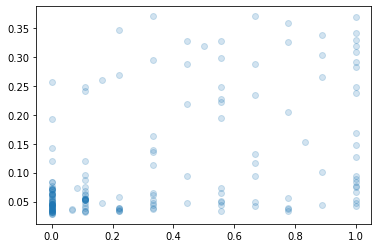

In [19]:

#print(validArr.shape)

test = validArr[1,:,:]
#np.corrcoef(test[1], test[2])

#go through each validation step
for i in range(validArr.shape[0]): 
    subDf = pd.DataFrame(validArr[i].T)
    subDf.columns = ["loss", "pred", "true"]
    corr = np.corrcoef(subDf["pred"], subDf["true"])
    print(corr)
    
plt.scatter(subDf["true"], subDf["pred"], alpha=.2)

In [20]:
validArr[0]

array([[ 6.98223070e-04,  8.37797582e-01,  1.05354607e+00,
         1.89158861e-02,  1.05354607e+00,  3.38700145e-01,
         6.98222837e-04,  6.98223244e-04,  1.05354607e+00,
         6.98222779e-04,  8.37797582e-01,  6.98223128e-04,
         6.98223070e-04,  6.98223070e-04,  6.46740317e-01,
         6.98223070e-04,  6.98222953e-04,  1.89158823e-02,
         4.80374604e-01,  6.18249178e-02,  6.98223128e-04,
         1.20466547e-02,  1.05354607e+00,  1.29425272e-01,
         2.21717000e-01,  6.98223070e-04,  6.98223070e-04,
         6.98222953e-04,  1.89158786e-02,  8.37797463e-01,
         1.05354607e+00,  3.38700145e-01,  1.29425302e-01,
         6.46740437e-01,  6.98223128e-04,  6.98223419e-04,
         1.89158823e-02,  3.72839756e-02,  1.89158861e-02,
         8.37797582e-01,  8.37797582e-01,  6.98223128e-04,
         3.38700145e-01,  1.05354607e+00,  1.29425272e-01,
         6.98223361e-04,  1.05354607e+00,  6.46740437e-01,
         6.98223128e-04,  1.89158823e-02,  6.46740437e-0

In [21]:
validDf.loc[validDf["iter"] == 1400, "true"]

Series([], Name: true, dtype: float64)

In [22]:
#check memory 
t = torch.cuda.mem_get_info()

used = torch.cuda.memory_allocated(device="cuda:4")
#proportion of free memory 
#print("used: " used / t[1])
print("used: " + str(t[0]/t[1]))

RuntimeError: Invalid device argument.